# Model for single mode squeezed vacuum

We test the boson sampling operator (no training) 
on coherent states

We compare with theory

nonlinearxwaves@gmail.com<br>
@created 27 January 2021<br>
@version 1 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
import math
from thqml import phasespace as ps
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

## Dimension

In [6]:
N = 2

## Build vacuum by the Gaussian state

In [7]:
vacuum = ps.VacuumLayer(N)

## Squeezer for mode 0

In [8]:
r_np=0.8;
theta_np=np.pi/4;
squeezer=ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=0)

## Build the model

In [9]:
xin = tf.keras.layers.Input(N)
x1, a1 = squeezer(xin)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [10]:
cov_layer = ps.covariance(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)
[[0.897684276 -1.67978024]
 [-1.67978024 4.25724459]]


# Evaluate the Qtransform with calculated covariance and displacemente

In [11]:
Qrho = ps.QTransform(cov0, d0)

In [12]:
# test the call to the Q-trasform
kin = tf.zeros_like(d0)
Qrho(kin)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.75]], dtype=float32)>

# Test the Pr operator 

Probability of zero photon

In [13]:
ps.Pr([0], Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.75]], dtype=float32)>

Probability of one photon

In [14]:
ps.Pr([1], Qrho)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.49e-08], dtype=float32)>

Probability of two photons

In [15]:
ps.Pr([2], Qrho)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.16], dtype=float32)>

## Define a function with the expected theoretical value

In [16]:
def Psqueeze(n, r):
    # returh the theory value for the Boson sampling for coherent states
    
    scale = 1.0
    if n % 2 ==0 :
        scale = scale/np.cosh(r)
        scale = scale*np.power(np.tanh(r), n)
        scale = scale*np.math.factorial(n)
        scale = scale/np.power(2.0,n)
        n2 = n//2 # floor division
        scale = scale/np.power(np.math.factorial(n2),2)
    else:
        scale = 0.0
    
    return scale   

## Make a plot versus the probability (may take some minuts for nmax>5)

In [18]:
%%time
nmax=6
Pn = np.zeros([nmax,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(nmax):
    print('Computing Pn at n '+repr(nbar))
    Pn[nbar]=ps.Pr([nbar],Qrho).numpy()
    Pth[nbar]=Psqueeze(nbar,r_np)
    xaxis[nbar]=nbar
print('Done')

Computing Pn at n 0
Computing Pn at n 1
Computing Pn at n 2
Computing Pn at n 3
Computing Pn at n 4
Computing Pn at n 5
Done
CPU times: user 32.9 s, sys: 94.3 ms, total: 33 s
Wall time: 33 s


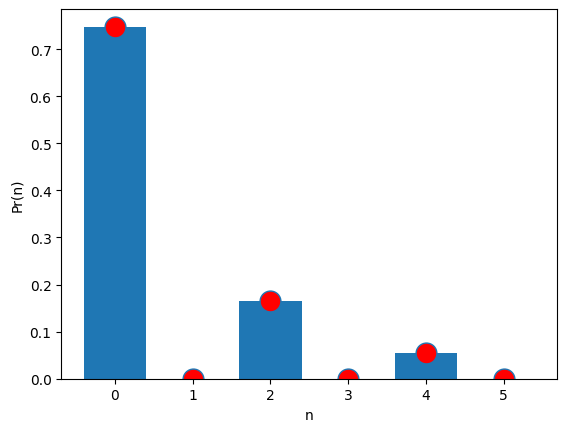

In [19]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=15, markerfacecolor='red', linestyle='none')
plt.xlabel('n');
plt.ylabel('Pr(n)');
# save in a figure
plt.savefig('BosonSamplingExample2.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots)